# Project analysis

In [1]:
import os
import sys
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import git

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set()

sys.path.append(os.path.realpath(os.path.join(os.getcwd(), os.pardir, os.pardir)))
print(os.path.realpath(os.path.join(os.getcwd(), os.pardir, os.pardir)))

from gitlytic import settings
from gitlytic.dataloader import load_project_commit_df
from gitlytic.project import get_project_output_dir_by_name, get_project_path

/home/skupsala/code/gitlytic


#### Project name (set this)

In [2]:
PROJECT_NAME = 'datascience2'

Load commits

In [3]:
df = load_project_commit_df(get_project_path(PROJECT_NAME))

Loading commits dataframe for datascience2


In [4]:
df.set_index(['repo_name', 'author_email', 'commit_hash'], drop=False, inplace=True)
df.head()

repo_name  \
repo_name author_email        commit_hash                                          
pandas    wesmckinn@gmail.com 9d0080576446de475d34b0dbb58389b15cd4f529    pandas   
                              ec1a0a2a2571dc2c1c26612b374d4a66b22f0938    pandas   
                              1eeadf4e401647faa20911f531bc05c1872262ea    pandas   
                              445114e1b20da8d4976c8d9050aa90c5bd508c54    pandas   
                              c6b236db73ff81007909be6406f0e484edc4a9eb    pandas   

                                                                                                     commit_hash  \
repo_name author_email        commit_hash                                                                          
pandas    wesmckinn@gmail.com 9d0080576446de475d34b0dbb58389b15cd4f529  9d0080576446de475d34b0dbb58389b15cd4f529   
                              ec1a0a2a2571dc2c1c26612b374d4a66b22f0938  ec1a0a2a2571dc2c1c26612b374d4a66b22f0938   
                              1eeadf4e401647faa20911f531bc05c1872262ea  1eeadf4e401647faa20911f531bc05c1872262ea   
                              445114e1b20da8d4976c8d9050aa90c5bd508c54  445114e1b20da8d4976c8d9050aa90c5bd508c54   
                              c6b236db73ff81007909be6406f0e484edc4a9eb  c6b236db73ff81007909be6406f0e484edc4a9eb   

                                                                         author_name  \
repo_name author_email        commit_hash                                              
pandas    wesmckinn@gmail.com 9d0080576446de475d34b0dbb58389b15cd4f529  Wes McKinney   
                              ec1a0a2a2571dc2c1c26612b374d4a66b22f0938  Wes McKinney   
                              1eeadf4e401647faa20911f531bc05c1872262ea  Wes McKinney   
                              445114e1b20da8d4976c8d9050aa90c5bd508c54  Wes McKinney   
                              c6b236db73ff81007909be6406f0e484edc4a9eb  Wes McKinney   

                                                                               author_email  \
repo_name author_email        commit_hash                                                     
pandas    wesmckinn@gmail.com 9d0080576446de475d34b0dbb58389b15cd4f529  wesmckinn@gmail.com   
                              ec1a0a2a2571dc2c1c26612b374d4a66b22f0938  wesmckinn@gmail.com   
                              1eeadf4e401647faa20911f531bc05c1872262ea  wesmckinn@gmail.com   
                              445114e1b20da8d4976c8d9050aa90c5bd508c54  wesmckinn@gmail.com   
                              c6b236db73ff81007909be6406f0e484edc4a9eb  wesmckinn@gmail.com   

                                                                               author_date  \
repo_name author_email        commit_hash                                                    
pandas    wesmckinn@gmail.com 9d0080576446de475d34b0dbb58389b15cd4f529 2009-07-31 15:07:16   
                              ec1a0a2a2571dc2c1c26612b374d4a66b22f0938 2009-08-05 02:32:49   
                              1eeadf4e401647faa20911f531bc05c1872262ea 2009-08-05 02:33:13   
                              445114e1b20da8d4976c8d9050aa90c5bd508c54 2009-08-05 03:17:29   
                              c6b236db73ff81007909be6406f0e484edc4a9eb 2009-08-05 03:30:16   

                                                                       committer_name  \
repo_name author_email        commit_hash                                               
pandas    wesmckinn@gmail.com 9d0080576446de475d34b0dbb58389b15cd4f529   Wes McKinney   
                              ec1a0a2a2571dc2c1c26612b374d4a66b22f0938   Wes McKinney   
                              1eeadf4e401647faa20911f531bc05c1872262ea   Wes McKinney   
                              445114e1b20da8d4976c8d9050aa90c5bd508c54   Wes McKinney   
                              c6b236db73ff81007909be6406f0e484edc4a9eb   Wes McKinney   

                                                                            committer_email  \
repo_nam

## Project overview
TODO
- Commits per week chart over X weeks
- LOC over time
- Author count over time
- New authors per week for last X weeks
- Files over time
- Directories over time
- Fix commits over time

#### Commit and author count

In [5]:
total_commit_count = len(df)
print("Commit count: {}".format(total_commit_count))
total_author_count = df['author_email'].nunique()
print("Author count: {}".format(total_author_count))

Commit count: 34102
Author count: 1903


In [6]:
def get_top_contributors(df, top_count=10):
    commit_count = len(df)
    top_committers = df.groupby('author_email').size().sort_values(ascending=False)[:top_count].to_frame(name='commit_count')
    top_committers['percentage_of_commits'] = (top_committers['commit_count'] / commit_count) * 100.0
    return top_committers

In [7]:
repos_by_hour = {}
for repo_name, repo_df in df.groupby(level=0):
    print()
    print('-----------------------------------------------------------')
    print('Repo: {}'.format(repo_name))
    print('Commits: {}'.format(len(repo_df)))
    print('Authors: {}'.format(repo_df['author_email'].nunique()))
    oldest_commit = repo_df.iloc[-1]
    age_delta = datetime.now() - oldest_commit.author_date.to_pydatetime()
    age_delta_years = age_delta.days // 366 # This is not exact - precise enough for this purpose
    print('Age: {years} year(s) and {days} day(s)'.format(years=age_delta_years, days=(age_delta.days-age_delta_years*365)))
    print('First commit was written {} by {}'.format(oldest_commit.author_date.to_pydatetime(), oldest_commit.author_name))
    print('For nostalgy, here it is:')
    print(oldest_commit.subject)
    print()
    print('Since that a lot have happened...')
    TOP_COUNT = 5
    print('Here you see top {} contributors portion of the contributions'.format(TOP_COUNT))
    repo_top_contributors = get_top_contributors(repo_df, top_count=TOP_COUNT)
    print(repo_top_contributors.sum())
    print(repo_top_contributors)
    print()
    print('Last three months top {} contributors'.format(TOP_COUNT))
    last_three_months_commits = repo_df[repo_df['author_date'] >= (datetime.today() - timedelta(days=3 * 30))]
    last_three_months_top_contributors = get_top_contributors(last_three_months_commits, top_count=TOP_COUNT)
    print(last_three_months_top_contributors)
    print()
    print('Last two weeks top {} contributors'.format(TOP_COUNT))
    last_two_weeks_commits = repo_df[repo_df['author_date'] >= (datetime.today() - timedelta(days=14))]
    last_two_weeks_top_contributors = get_top_contributors(last_two_weeks_commits, top_count=TOP_COUNT)
    print(last_two_weeks_top_contributors)
    author_date_index = pd.DatetimeIndex(repo_df['author_date'])
    print(author_date_index.hour)
    repos_by_hour[repo_name] = repo_df.groupby(author_date_index.hour)['author_email'].count()
    


-----------------------------------------------------------
Repo: numpy
Commits: 17494
Authors: 772
Age: 0 year(s) and 0 day(s)
First commit was written 2018-02-22 08:34:19 by Charles Harris
For nostalgy, here it is:
Merge pull request #10641 from charris/post-1.14.1-update

Since that a lot have happened...
Here you see top 5 contributors portion of the contributions
commit_count             8848.000000
percentage_of_commits      50.577341
dtype: float64
                           commit_count  percentage_of_commits
author_email                                                  
charlesr.harris@gmail.com          3524              20.144049
oliphant@enthought.com             1989              11.369612
cournape@gmail.com                 1525               8.717274
pearu.peterson@gmail.com           1058               6.047788
pav@iki.fi                          752               4.298617

Last three months top 5 contributors
                                 commit_count  percentage_of

/home/skupsala/code/gitlytic/gl/lib/python3.5/site-packages/ipykernel_launcher.py:3: FutureWarning: 'author_email' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  This is separate from the ipykernel package so we can avoid doing imports until


### Commits over time

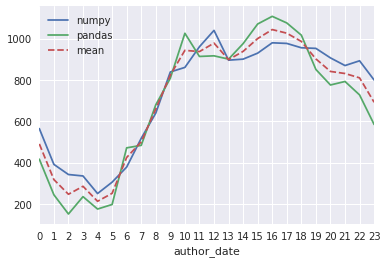

In [8]:
for repo_name, by_hour in repos_by_hour.items():
    ax = by_hour.plot(xticks=np.arange(24), label=repo_name)
    ax.legend()
mean_by_hour_df = pd.concat(list(repos_by_hour.values()), axis=1)
ax = mean_by_hour_df.mean(axis=1).plot(xticks=np.arange(24), label='mean', style='--')
ax.legend()

### Subject line distributions

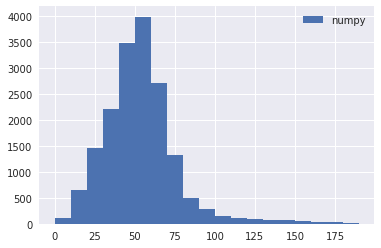

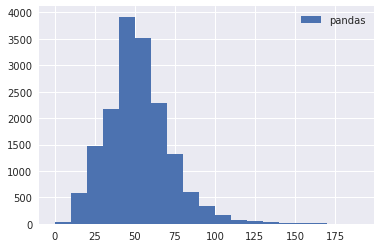

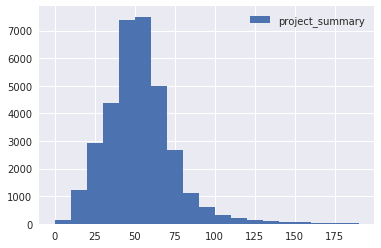

In [9]:
for repo_name, repo_df in df.groupby(level=0):
    plt.figure()
    s = pd.Series(repo_df['subject'].str.len().values)
    ax = s.dropna().hist(bins=[n for n in range(0, 200, 10)], label=repo_name)
    ax.legend()

plt.figure()
s = pd.Series(df['subject'].str.len().values)
ax = s.dropna().hist(bins=[n for n in range(0, 200, 10)], label='project_summary')
ax.legend()

### Commit size by changed file count distributions

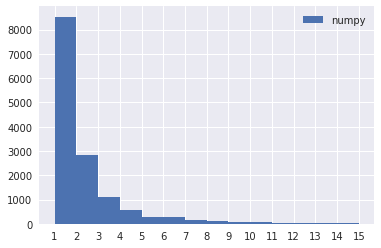

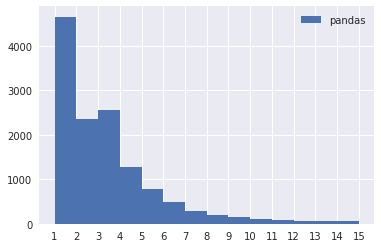

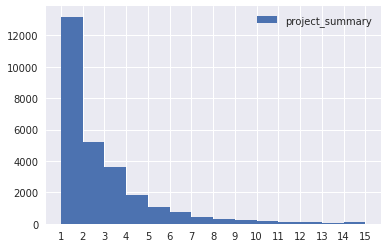

In [10]:
for repo_name, repo_df in df.groupby(level=0):
    plt.figure()
    plt.xticks(np.arange(1, 16, 1.0))
    s = pd.Series(repo_df['changed_file_count'])
    ax = s.dropna().hist(bins=[n for n in range(1, 16, 1)], label=repo_name)
    ax.legend()

plt.figure()
plt.xticks(np.arange(1, 16, 1.0))
s = pd.Series(df['changed_file_count'])
ax = s.dropna().hist(bins=[n for n in range(1, 16, 1)], label='project_summary')
ax.legend()

### Commit size by changed lines 

#### Please notice changing commit category size!


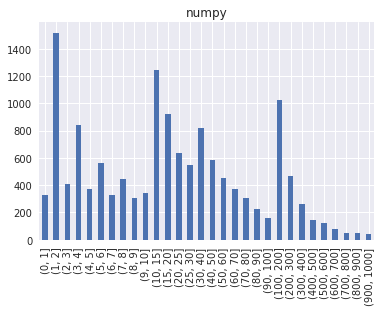

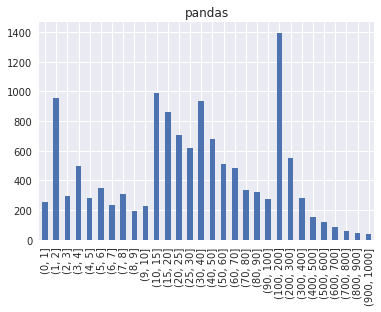

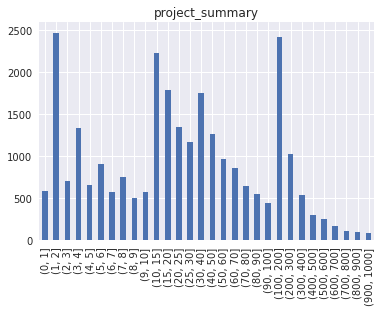

In [11]:
bins = list(range(0, 10)) + [n for n in range(10, 30, 5)] + [n for n in range(30, 100, 10)] + [n for n in range(100, 1100, 100)]
for repo_name, repo_df in df.groupby(level=0):
    data = repo_df[repo_df['is_merge'] == False]
    data = pd.Series(data['insertions'] + data['deletions'])
    data = pd.cut(data, bins)
    plt.figure()
    data.value_counts(sort=False).plot(kind='bar', title=repo_name)

plt.figure()
data = df[df['is_merge'] == False]
data = pd.Series(data['insertions'] + data['deletions'])
data = pd.cut(data, bins)
data.value_counts(sort=False).plot(kind='bar', title='project_summary')

### Authors over time

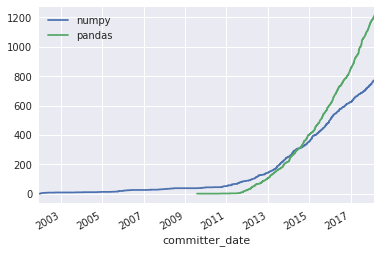

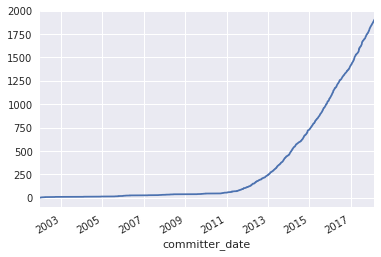

In [15]:
for repo_name, repo_df in df.groupby(level=0):
    authors_over_time = repo_df['author_email'].groupby(repo_df['committer_date']).agg(lambda x: list(x)).cumsum().apply(set).apply(len)
    ax = authors_over_time.plot(label=repo_name)
    ax.legend()
plt.figure()
authors_over_time = df['author_email'].groupby(df['committer_date']).agg(lambda x: list(x)).cumsum().apply(set).apply(len)
authors_over_time.plot(label='project_summary')
